# Ground magnetic perturbation forecasting

A full-earth ground magnetic perturbation forecasting model using deep learning

In this notebook, we shall see how to forecast ground magnetic perturbation across the northern hemisphere using solar wind measurements.

Vishal Upendran, Panos Tigas, Bashi Ferdousi, Teo Bloch, Mark Cheung, Siddha Ganju, Asti Bhat, Ryan McGranaghan, Yarin Gal


## Introduction

Ground magnetic field perturbation is currently estimated based on Magnetic Hydrodynamic (MHD) and empirical models. While useful, MHD models are computationally expensive for high-resolution models that are required for small-scale perturbation, and empirical models do not provide a dynamic forecast. 

In this study, we use Spherical Harmonics (SH) to create high-resolution global models of the northward ($\delta\mathrm{B}_\mathrm{N}$) and Eastward ($\delta\mathrm{B}_\mathrm{E}$) components of the perturbation with a lead time of 30 min. How do we do this?

We summarize 2-hours of solar wind conditions measured at L1 point (from the OMNI dataset) using Recurrent Neural Networks (RNNs) to generate a summary "hidden state" of the solar wind measurements. This state is then passed to a fully-connected layer of Multi Layer Perceptro (MLP) to generate a vector of coefficients. These coefficients are then contracted with a basis of spherical harmonics which is generated every forward pass depending on the locations of the different stations which have measurements. The output after the contraction operation is a set of ($\delta\mathrm{B}_\mathrm{N}$) and ($\delta\mathrm{B}_\mathrm{E}$) measurements at each station location.

In this notebook, we shall generate the forecast for the 2015 storm dataset, and visualize the global predictions with the targets as a time series.

## Table of contents

1. Notebook setup
2. Download and read data
3. Setup model
4. Generate forecast
5. Time series of forecast

## Notebook setup

We first need to clone the repo and install packages. Then, we will need to import them.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import h5py
from astropy.time import Time
import numpy as np
import glob
import pandas as pd
import re
from datetime import datetime
import torch
from torch.utils import data
from matplotlib import cm

In [17]:
import matplotlib as mpl

## Helper functions 

Define some important helper functions to be used later

In [2]:
import sys
sys.path.append('../')
from dataloader import SuperMAGIAGADataset,OMNIDataset,ShpericalHarmonicsDatasetBucketized
from utils.data_utils import get_omni_data,get_iaga_data_as_list
from utils.splitter import generate_indices
from utils.plot import SqueezedNorm
from metricgen import EventMetrics,Generate_metrics
from Forecaster import Forecaster,Generate_complete_weimer_forecast,Generate_weimer_forecast
from models.geoeffectivenet import *
import pickle
torch.set_default_dtype(torch.float64)  # this is important else it will overflow

In [3]:
md = {'NeuralRNNWiemer_HidddenSuperMAG':NeuralRNNWiemer_HidddenSuperMAG,
        'NeuralRNNWiemer':NeuralRNNWiemer}

## Download and read data

## Load hyperparameters

> Hyperparameters: Free parameters that are non-trainable, and  are fixed for a particular task

In [104]:
# Cell to download data from the bucket
!mkdir -p Storm
!gsutil cp -r gs://storm_subset/ Storm/

Copying gs://storm_subset/2011/f107.npz...
Copying gs://storm_subset/2011/supermag_omni_data.npz...                        
Copying gs://storm_subset/2015/f107.npz...                                      
Copying gs://storm_subset/2015/supermag_omni_data.npz...                        
- [4 files][ 50.8 MiB/ 50.8 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://storm_subset/model/Best/epoch=8-step=3077.ckpt...
Copying gs://storm_subset/model/Best/scalers.p...                               
- [6 files][ 57.4 MiB/ 57.4 MiB]                                                
Operation completed over 6 objects/57.4 MiB.                                     


In [106]:
future_length = 1 #WAS DEFAULT IN THE CODE
past_omni_length = 120
nmax = 20
targets = ["dbe_nez", "dbn_nez"]
lag = 30
learning_rate = 5e-3
batch_size = 8500
omni_resolution = 1
dropout_prob = 0.7
l2reg = 5e-5
n_hidden = 8
loss = 'MAE'
modname = "NeuralRNNWiemer"
basepath = "Storm/storm_subset/model/Best/"
# load scaler to unstandardize data
scalers = pickle.load(open(f"{basepath}scalers.p", "rb"))
_mean, _std = scalers["supermag"]

dbe_mean, dbn_mean = _mean
dbe_std, dbn_std = _std

FileNotFoundError: [Errno 2] No such file or directory: 'Storm/model/Best/scalers.p'

### Download data

In [101]:
YEAR = 2011
dataset = np.load(f"Storm/{YEAR}/supermag_omni_data.npz")
supermag_data = SuperMAGIAGADataset(dataset['dates'],dataset['data'],dataset['features'])
omni_data = OMNIDataset(pd.DataFrame(data=dataset['omni'],columns=dataset['omni_features']))
storm_idx = dataset['idx']

FileNotFoundError: [Errno 2] No such file or directory: 'Storm/Weimer/2011/supermag_omni_data.npz'

In [93]:
storm_dataset = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,storm_idx,
        f107_dataset=f"Storm/{YEAR}/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=scalers,training_batch=False,nmax=nmax,inference=True)
storm_loader = data.DataLoader(storm_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

extracting f107
using existing scaler


In [94]:
targets_idx = [np.where(storm_dataset.supermag_features == target)[0][0] for target in targets]

## Setup model

In [47]:
NN_md = md[modname]
model = NN_md.load_from_checkpoint(f'{basepath}/epoch=8-step=3077.ckpt', strict=False, 
                                                 past_omni_length=past_omni_length,
                                                 future_length=future_length,
                                                 supermag_features=storm_dataset.supermag_features,
                                                 omni_features=storm_dataset.omni_features,
                                                 nmax=nmax,omni_resolution=omni_resolution,
                                                 targets_idx=targets_idx,learning_rate = learning_rate,
                                                 l2reg=l2reg,
                                                 dropout_prob=dropout_prob,
                                                 n_hidden=n_hidden,
                                                 loss=loss)

Constructing spherical harmonics functions


In [48]:
if torch.cuda.is_available():
    model = model.cuda().double()
else:
    model = model.double()

## Generate forecast

In [95]:
dbe_index = np.where(storm_dataset.supermag_features == 'dbe_nez')[0][0]
dbn_index = np.where(storm_dataset.supermag_features == 'dbn_nez')[0][0]
print(dbn_index,dbe_index)
target_index = {'dbe':dbe_index,'dbn':dbn_index}

3 2


In [96]:
Predictions,Targets,All_times_coeff,Date_arr,MLT_sup_all,Mcolat_sup_all = Forecaster(storm_loader,model,
                                                                                     dbe_mean,dbe_std,dbn_mean,
                                                                                     dbn_std,target_index)

## Time series of forecast

In [97]:
Date_arr['dbe'].shape,Predictions['dbe'].shape,Targets['dbe'].shape

((2581, 1, 1), (2581, 175), (2581, 175))

### How does the forecast for one (any random) station look like?

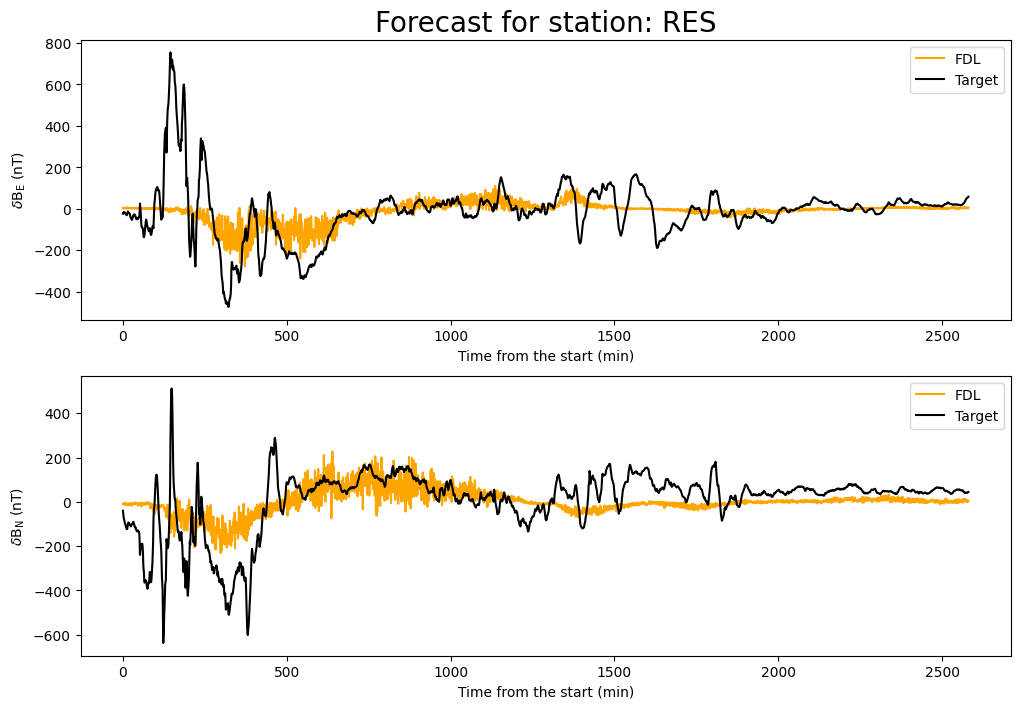

In [99]:
station_index = 100
plt.style.use('default')
fig,ax = plt.subplots(2,1,figsize=(12,8))

ax[0].plot(Predictions['dbe'][:,station_index],'orange',label='FDL')
ax[0].plot(Targets['dbe'][:,station_index],'k',label='Target')
ax[0].set_ylabel("$\\delta \mathrm{B}_{\mathrm{E}}$ (nT)")
ax[0].set_xlabel("Time from the start (min)")
ax[0].legend(loc='best')
ax[0].set_title(f"Forecast for station: {dataset['stations'][station_index]}",fontsize=20)

ax[1].plot(Predictions['dbn'][:,station_index],'orange',label='FDL')
ax[1].plot(Targets['dbn'][:,station_index],'k',label='Target')
ax[1].set_ylabel("$\\delta \mathrm{B}_{\mathrm{N}}$ (nT)")
ax[1].set_xlabel("Time from the start (min)")
ax[1].legend(loc='best')

### How does the joint distribution of forecast and targets look like?


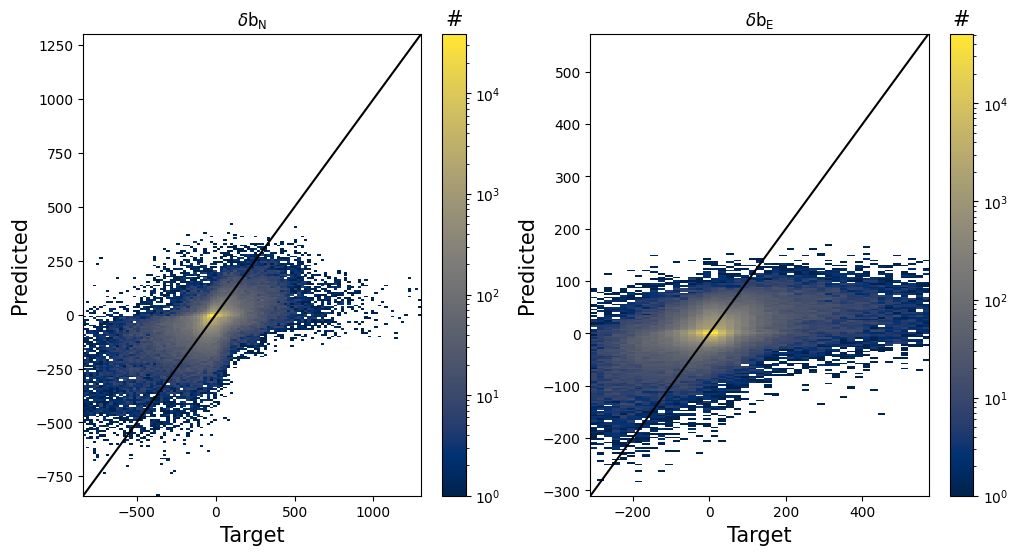

In [79]:
plt.style.use('default')
fig,ax = plt.subplots(1,2,figsize=(12,6))

bad_indices = np.isnan(Targets['dbn']) | np.isnan(Predictions['dbn'])
im = ax[0].hist2d(Targets['dbn'][~bad_indices],Predictions['dbn'][~bad_indices],bins=150,cmap='cividis',norm=mpl.colors.LogNorm())
ax[0].set_ylabel("Predicted",fontsize=15)
ax[0].set_xlabel("Target",fontsize=15)
ax[0].set_xlim([np.nanmin(Predictions['dbn'].ravel()),np.nanmax(Targets['dbn'].ravel())+0.5])
ax[0].set_ylim(ax[0].get_xlim())
limy=ax[0].get_ylim()[0]#0.94
limx=ax[0].get_xlim()[-1]-0.1#0.99
ax[0].set_title("$\delta \mathrm{b}_{\mathrm{N}}$")
cbar = fig.colorbar(im[3], ax=ax[0], orientation='vertical')
cbar.ax.set_title("#",fontsize=15)
limy=ax[0].get_ylim()
limx=ax[0].get_xlim()
x_1 = np.linspace(limx[0],limx[1],4)
y_1 = x_1-limx[0]+limy[0]
ax[0].plot(x_1,y_1,'k')


bad_indices = np.isnan(Targets['dbe']) | np.isnan(Predictions['dbe'])
im  = ax[1].hist2d(Targets['dbe'][~bad_indices],Predictions['dbe'][~bad_indices],bins=150,cmap='cividis',norm=mpl.colors.LogNorm())
ax[1].set_ylabel("Predicted",fontsize=15)
ax[1].set_xlabel("Target",fontsize=15)
ax[1].set_xlim([np.nanmin(Predictions['dbe'].ravel()),np.nanpercentile(Targets['dbe'].ravel(),99.8)+0.5])
ax[1].set_ylim(ax[1].get_xlim())
limy=ax[1].get_ylim()[0]#0.94
limx=ax[1].get_xlim()[-1]-0.1#0.99
ax[1].set_title("$\delta \mathrm{b}_{\mathrm{E}}$")
cbar = fig.colorbar(im[3], ax=ax[1], orientation='vertical')
cbar.ax.set_title("#",fontsize=15)
limy=ax[1].get_ylim()
limx=ax[1].get_xlim()
x_1 = np.linspace(limx[0],limx[1],4)
y_1 = x_1-limx[0]+limy[0]
ax[1].plot(x_1,y_1,'k')

### Forecast for the top-3 best and worst performing stations!

In [82]:
def plot_station(dt,fdl,targ,ax,**kwargs):
    l1 = ax.plot(dt,fdl,c="#00c5ff",label='FDL')
    ax.yaxis.label.set_color("#00c5ff")
    ax_tmp = ax.twinx()
    l2 = ax_tmp.plot(dt,targ,c="#181820",label=f"{kwargs['stat']}")
    ax.set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
    ax_tmp.set_ylabel("$\\delta \mathrm{b}_{\mathrm{H}}$ (nT)",fontsize=15)
    ax.set_title(f"{kwargs['metric']} = {kwargs['mval']:.2f} nT")
    lns = l1+l2
    labs = [l.get_label() for l in lns]
    ax.spines['left'].set_color("#00c5ff")
    ax.legend(lns, labs, loc='best')
    ax.xaxis.get_majorticklabels()
    ax.tick_params(axis='x', rotation=-45)
    limy=ax.get_ylim()[-1]#0.94
    limx=ax.get_xlim()[0]-0.1#0.99
    

In [83]:
dbh_pred_.shape,dbh_targ.shape

((3361, 108), (2581, 106))

In [88]:
pl_dt = pd.to_datetime(Date_arr['dbe'].ravel(),unit='s')
symh_value = dataset['symh']
stations = dataset['stations']

dbh_pred = np.sqrt(Predictions['dbe']**2+Predictions['dbn']**2)
dbh_targ = np.sqrt(Targets['dbe']**2+Targets['dbn']**2)

subset = ~np.isnan(dbh_targ).any(axis=0)[:len(stations)]
dbh_pred = dbh_pred[:,:len(stations)][:,subset]
dbh_targ = dbh_targ[:,:len(stations)][:,subset]
stations = stations[subset]

mae = np.nanmean(np.abs(dbh_pred-dbh_targ),axis=0)
notnan = ~np.isnan(mae) 
sort_mae = np.argsort(mae[notnan])

mae = mae[notnan]
dbh_pred = dbh_pred[:,notnan]
dbh_targ = dbh_targ[:,notnan]
stations = stations[notnan]

i_bz = np.where(storm_dataset.omni_features=='bz')
i_s,i_e = storm_dataset.sg_indices[0,-1],storm_dataset.sg_indices[-1,-1]+1
bz = storm_dataset.omni[i_s:i_e,i_bz]*scalers['omni'][1][i_bz]+scalers['omni'][0][i_bz]

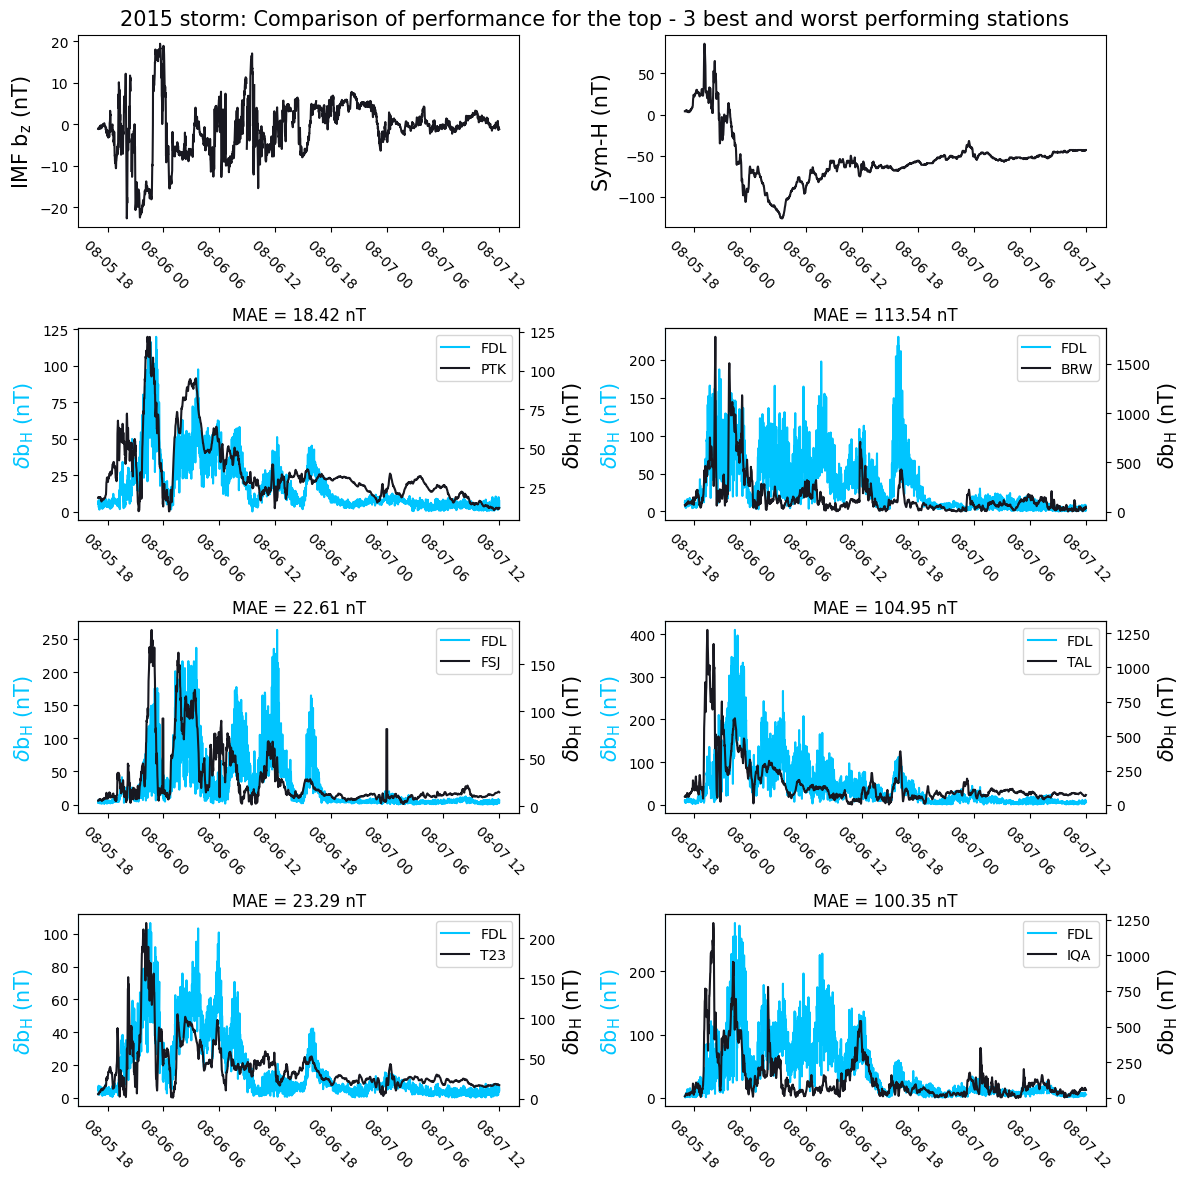

In [90]:
plt.style.use('default')
fig,ax = plt.subplots(4,2,figsize=(12,12))

ax[0,0].plot(pl_dt,bz.ravel(),c="#181820")
ax[0,0].set_ylabel("IMF $\mathrm{b}_{\mathrm{z}}$ (nT)",fontsize=15)
ax[0,0].xaxis.get_majorticklabels()
ax[0,0].tick_params(axis='x', rotation=-45)
limy=ax[0,0].get_ylim()[-1]#0.94
limx=ax[0,0].get_xlim()[0]-0.1#0.99
    
ax[0,1].plot(pl_dt,symh_value.ravel(),c="#181820")
ax[0,1].set_ylabel("Sym-H (nT)",fontsize=15)
ax[0,1].xaxis.get_majorticklabels()
ax[0,1].tick_params(axis='x', rotation=-45)
limy=ax[0,1].get_ylim()[-1]#0.94
limx=ax[0,1].get_xlim()[0]-0.1#0.99

for i in np.arange(3):
    plot_station(pl_dt,dbh_pred[:,sort_mae[i]],dbh_targ[:,sort_mae[i]],ax[i+1,0],
                 metric='MAE',mval=mae[sort_mae[i]],pno=2*i,stat=stations[sort_mae[i]])
for i in np.arange(3):
    plot_station(pl_dt,dbh_pred[:,sort_mae[-i-1]],dbh_targ[:,sort_mae[-i-1]],ax[i+1,1],
                 metric='MAE',mval=mae[sort_mae[-i-1]],pno=2*i+1,stat=stations[sort_mae[-i-1]])
fig.suptitle(f"{YEAR} storm: Comparison of performance for the top - 3 best and worst performing stations",fontsize=15)
fig.tight_layout()

## Forecast all over the Earth

### Generate latitude-longitude grid

In [45]:
MLT_sup_all.keys()

dict_keys(['dbe', 'dbn'])

In [89]:
_mlt = np.linspace(np.nanmin(MLT_sup_all['dbe']),np.nanmax(MLT_sup_all['dbe']),100)
_colat = np.linspace(np.nanmin(Mcolat_sup_all['dbe']),np.nanmax(Mcolat_sup_all['dbe']),360)
_mlt,_colat = np.meshgrid(_mlt,_colat)
_basis = basis_matrix(nmax ,_mlt, _colat)


### Transform coefficients to forecast

In [108]:
fdl_on_grid_gif = {'dbe':[],'dbn':[]}

fdl_on_grid_gif['dbn'] = np.einsum('bij,lj->bil',_basis,All_times_coeff['dbn'])
fdl_on_grid_gif['dbe'] = np.einsum('bij,lj->bil',_basis,All_times_coeff['dbe'])

fdl_on_grid_gif['dbn'] = fdl_on_grid_gif['dbn']*dbn_std + dbn_mean
fdl_on_grid_gif['dbe'] = fdl_on_grid_gif['dbe']*dbe_std + dbe_mean

In [52]:
# Sanity check.
print(fdl_on_grid_gif['dbn'].shape,fdl_on_grid_gif['dbe'].shape)

(360, 100, 3361) (360, 100, 3361)


### Make a video!

In [57]:
from celluloid import Camera

In [95]:
import mplcyberpunk

In [162]:
plt.style.use("dark_background")

/tmp/ipykernel_571642/830238015.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


Text(0.5, 0, 'Northward magnetic field perturbation ($\\delta\\mathrm{B}_{\\mathrm{N}}$) (nT)')

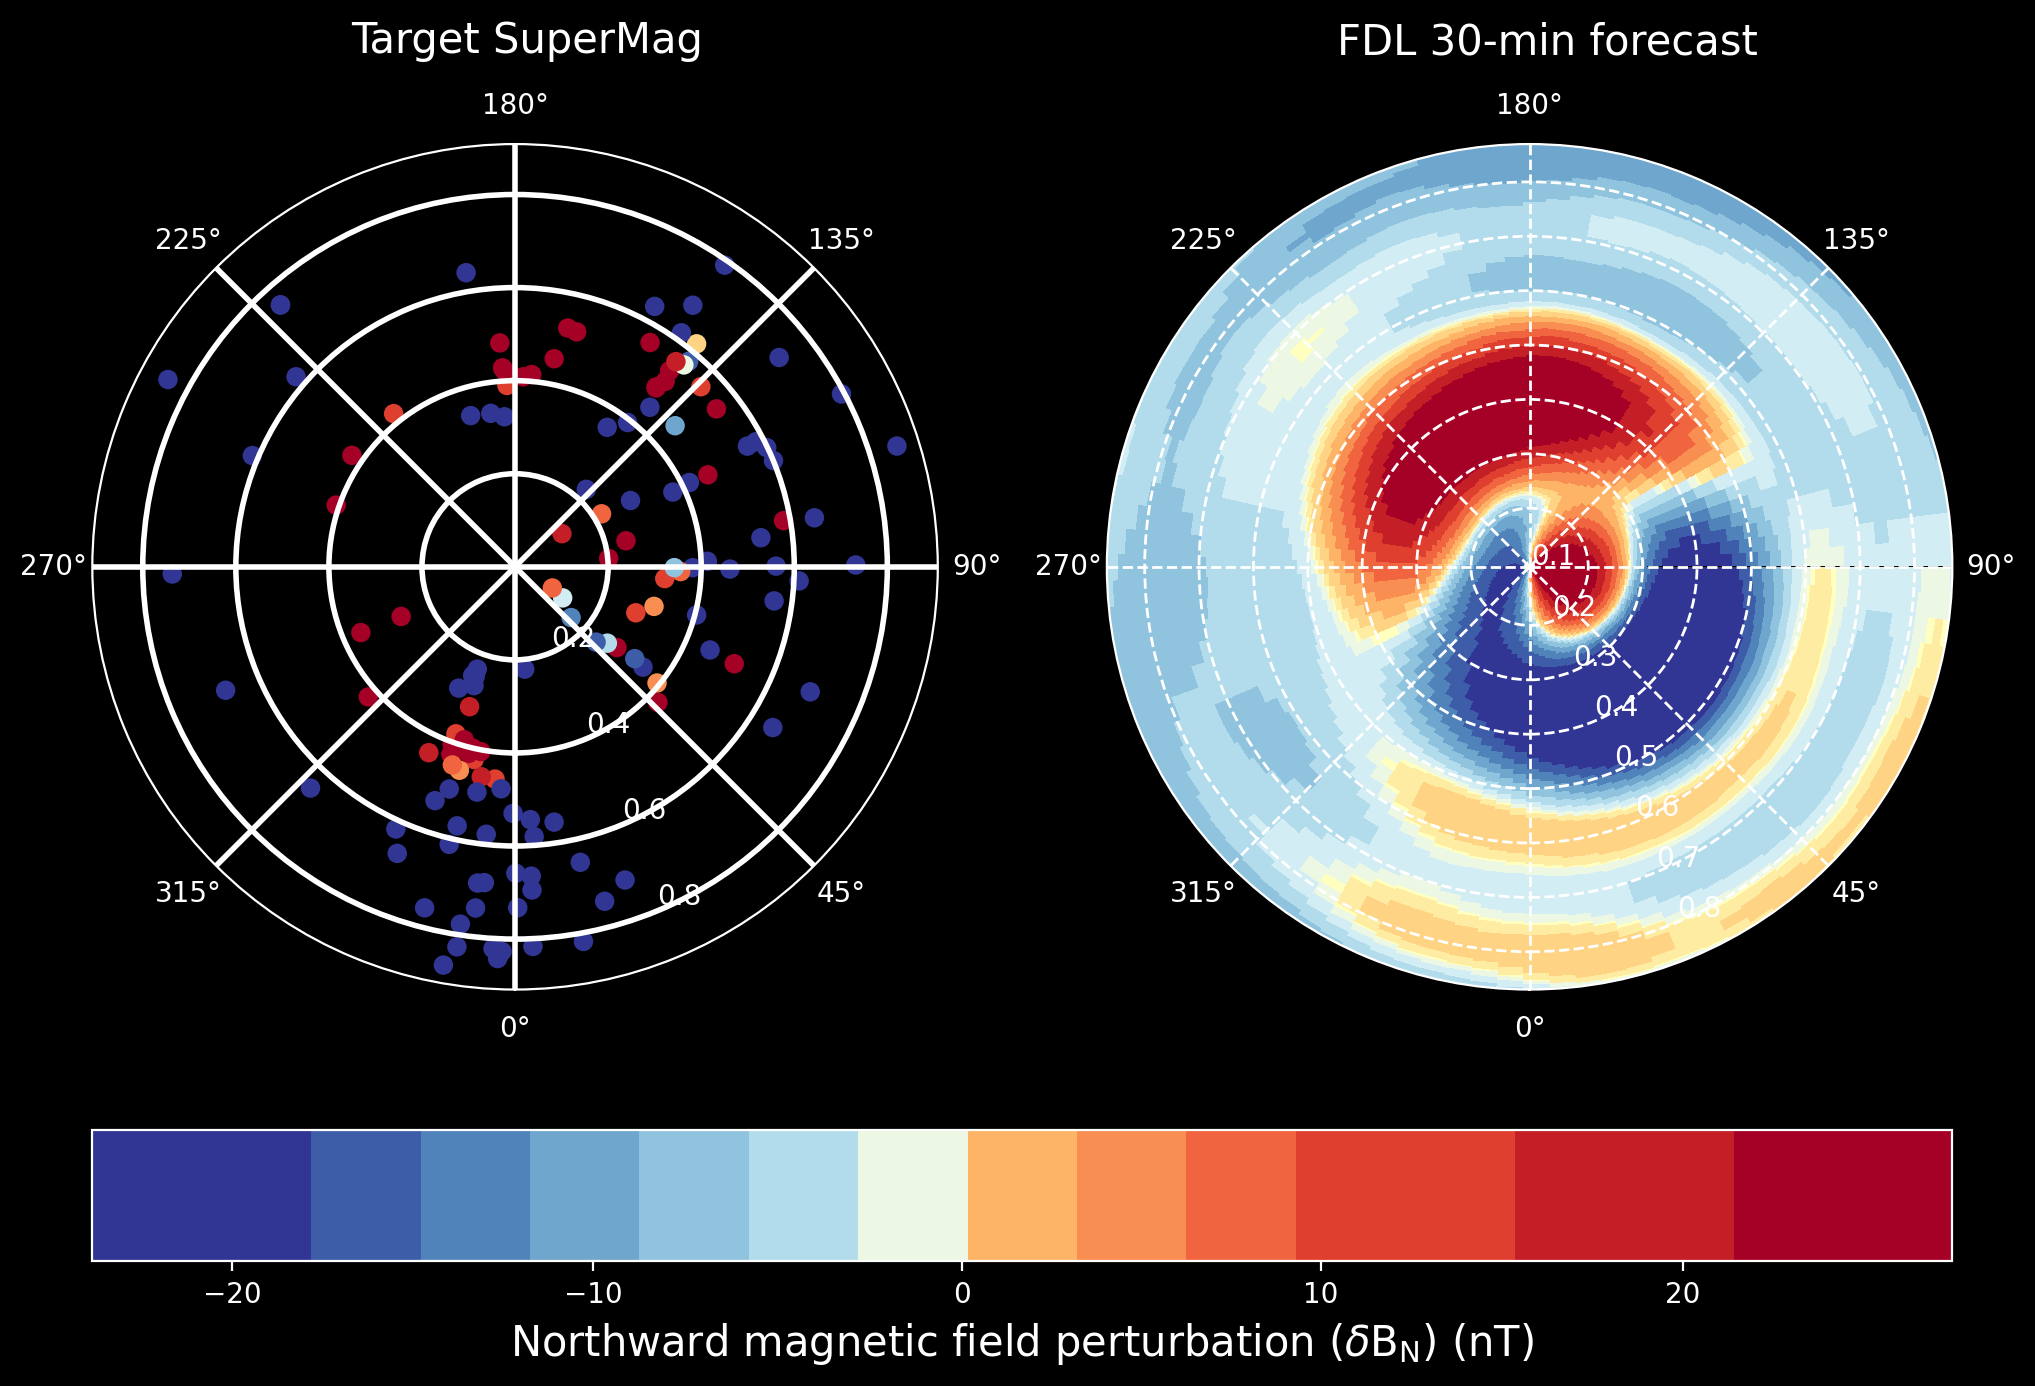

In [190]:
k = 'dbn'
f = 1
fig1 = plt.figure(figsize=(12*f,8*f),dpi=200)
gs = fig1.add_gridspec(8, 2)

theta = _mlt 
phi = _colat 
cmap=cm.get_cmap("RdYlBu_r",17)
ax1 = fig1.add_subplot(gs[:-1,0], projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(gs[:-1,1], projection='polar')
ax2.set_theta_offset(-np.pi/2)
# ax3 = fig1.add_subplot(gs[:-1,2], projection='polar')
# ax3.set_theta_offset(-np.pi/2)
cax = fig1.add_subplot(gs[-1,:])
time_ind=1500
d = storm_dataset.dates[time_ind]
cax.cla()
dt = pd.to_datetime(d,unit='s')

dbH2 = fdl_on_grid_gif[k][...,time_ind] #np.sqrt(np.square(Targets['dbe'][:,:,start:end+1])+np.square(Targets['dbn'][:,:,start:end+1]))

maxval = np.nanpercentile(dbH2,95)
minval = np.nanpercentile(dbH2,5)
norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=np.nanmean(dbH2), s1=2, s2=2)

dbH = fdl_on_grid_gif[k][...,time_ind] #np.sqrt(np.square(fdl_on_weimergrid_gif['dbe'][:,:,start:end+1][...,time_ind])+np.square(fdl_on_weimergrid_gif['dbn'][:,:,start:end+1][...,time_ind]))
c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)  
ax2.set_ylim([np.nanmin(Mcolat_sup_all[k][time_ind]),np.nanmax(Mcolat_sup_all[k][time_ind])])
ax2.grid(linewidth=1,color='white',linestyle='--')
ax2.text(3.5*f,1.1*f,f"FDL 30-min forecast",fontsize=15*f)

dbH = Targets[k][time_ind] #np.sqrt(np.square(Targets['dbe'][start:end+1][time_ind])+np.square(Targets['dbn'][start:end+1][time_ind]))
c3=ax1.scatter(MLT_sup_all[k][time_ind],Mcolat_sup_all[k][time_ind], c=dbH,cmap=cmap,norm=norm,s=36*f)
ax1.text(3.45*f,1.16*f,f"Target SuperMag",fontsize=15*f)
ax1.grid(linewidth=2,color='white')
fig1.colorbar(c3, cax=cax,orientation='horizontal')
cax.set_xlabel(r'Northward magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)',fontsize=15)


/tmp/ipykernel_571642/689572361.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


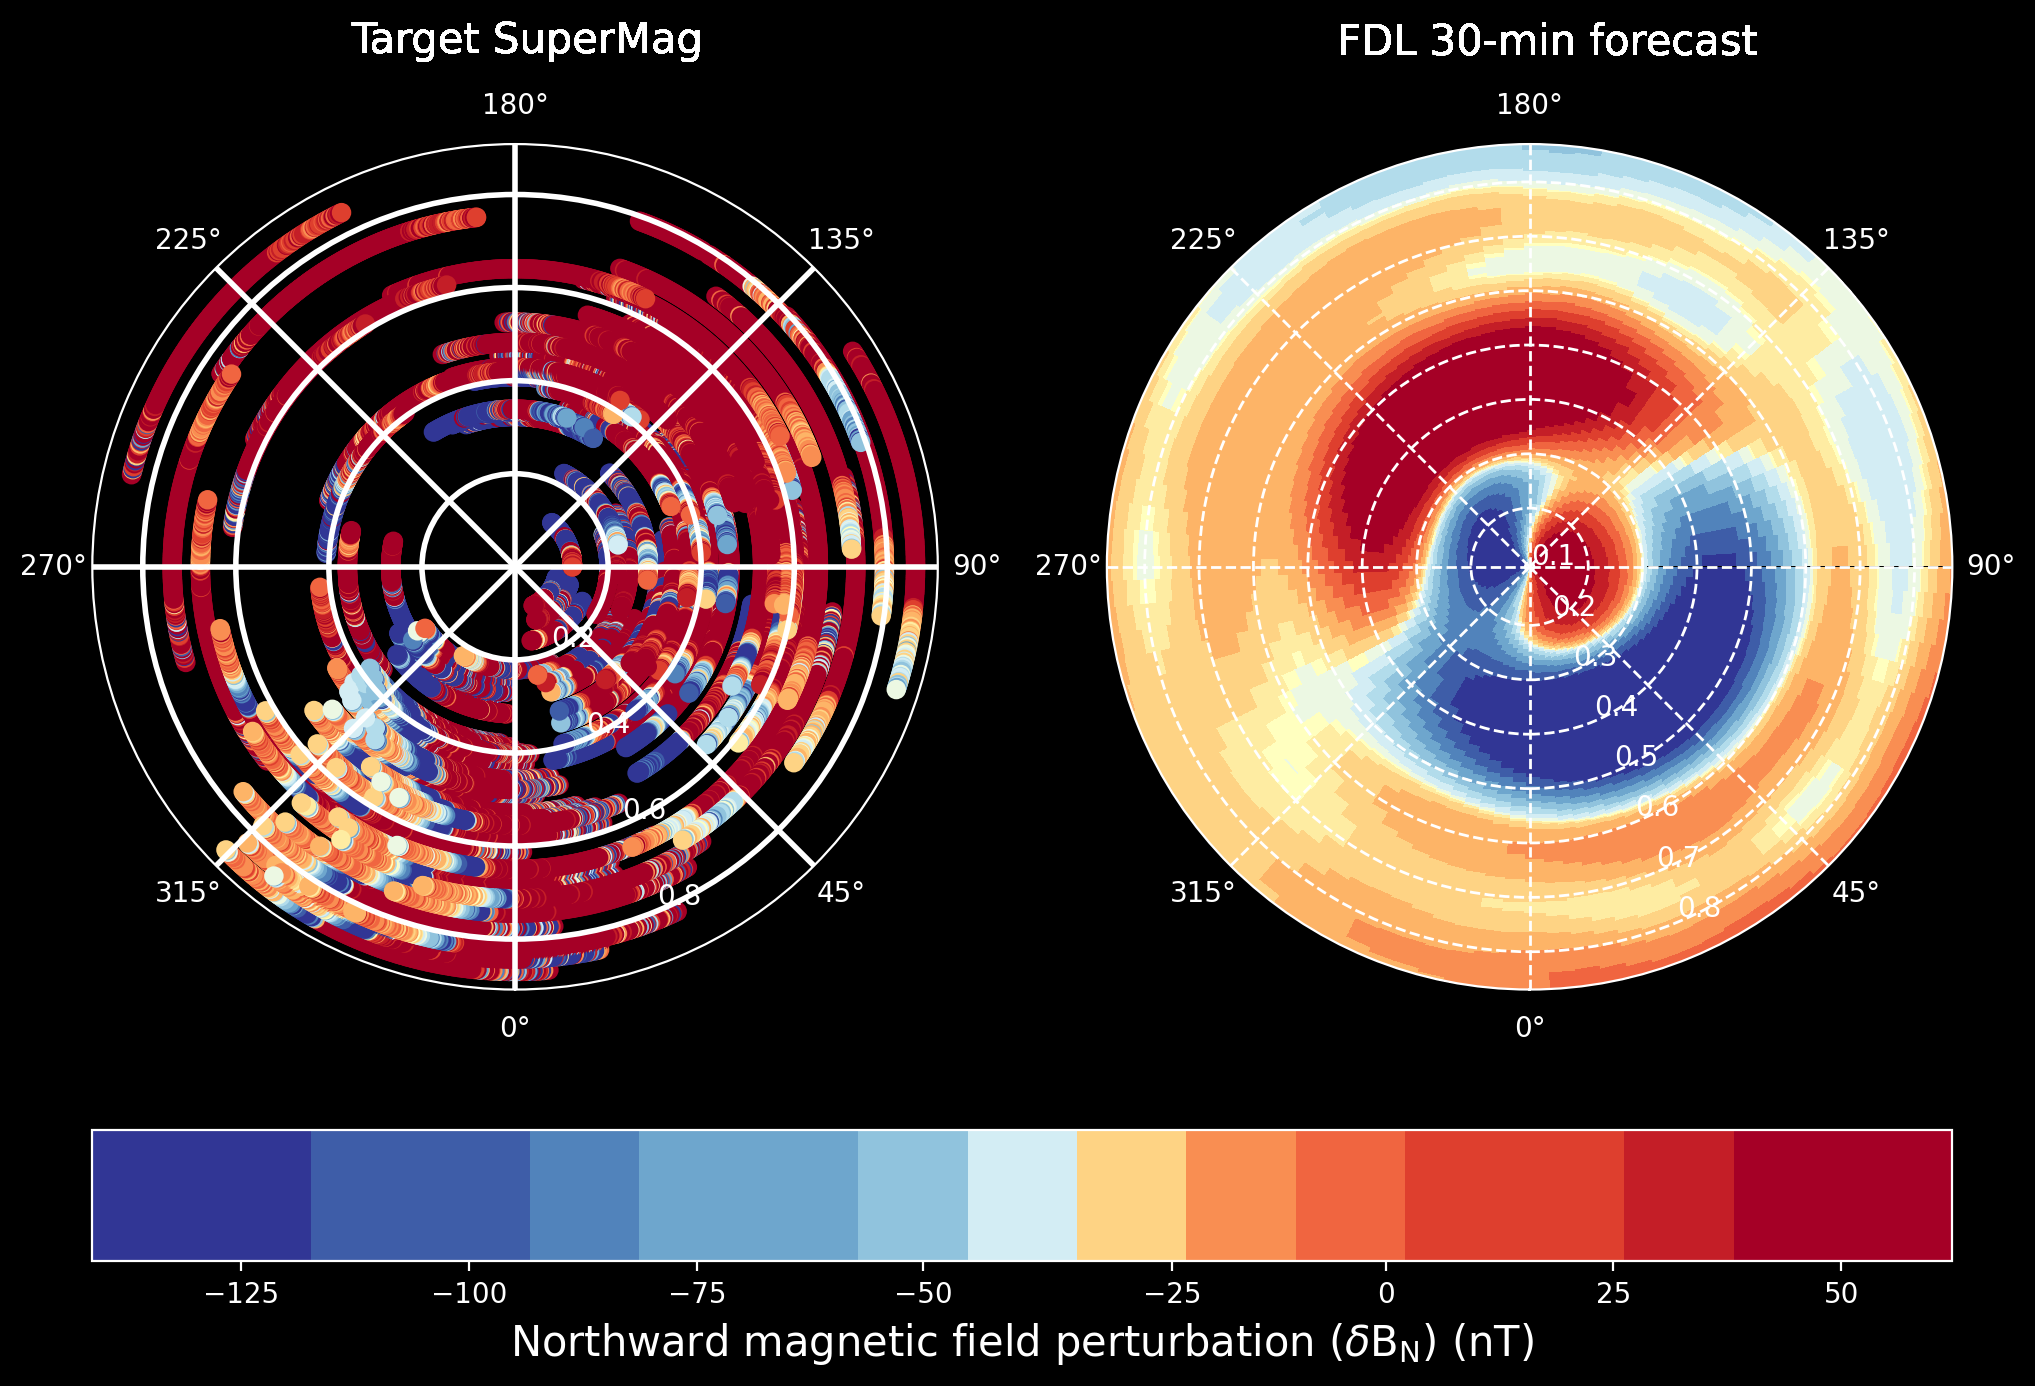

In [191]:
k = 'dbn'
f = 1
fig1 = plt.figure(figsize=(12*f,8*f),dpi=200)
gs = fig1.add_gridspec(8, 2)

camera = Camera(fig1)
theta = _mlt 
phi = _colat 
cmap=cm.get_cmap("RdYlBu_r",17)
ax1 = fig1.add_subplot(gs[:-1,0], projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(gs[:-1,1], projection='polar')
ax2.set_theta_offset(-np.pi/2)
# ax3 = fig1.add_subplot(gs[:-1,2], projection='polar')
# ax3.set_theta_offset(-np.pi/2)
cax = fig1.add_subplot(gs[-1,:])

for time_ind,d in enumerate(storm_dataset.dates[1500:][::10]):
    cax.cla()
    dt = pd.to_datetime(d,unit='s')
    
    dbH2 = fdl_on_grid_gif[k][...,time_ind] #np.sqrt(np.square(Targets['dbe'][:,:,start:end+1])+np.square(Targets['dbn'][:,:,start:end+1]))

    maxval = np.nanpercentile(dbH2,95)
    minval = np.nanpercentile(dbH2,5)
    norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=np.nanmean(dbH2), s1=2, s2=2)

    dbH = fdl_on_grid_gif[k][...,time_ind] #np.sqrt(np.square(fdl_on_weimergrid_gif['dbe'][:,:,start:end+1][...,time_ind])+np.square(fdl_on_weimergrid_gif['dbn'][:,:,start:end+1][...,time_ind]))
    c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)  
    ax2.set_ylim([np.nanmin(Mcolat_sup_all[k][time_ind]),np.nanmax(Mcolat_sup_all[k][time_ind])])
    ax2.grid(linewidth=1,color='white',linestyle='--')
    ax2.text(3.5*f,1.1*f,f"FDL 30-min forecast",fontsize=15*f)

    dbH = Targets[k][time_ind] #np.sqrt(np.square(Targets['dbe'][start:end+1][time_ind])+np.square(Targets['dbn'][start:end+1][time_ind]))
    c3=ax1.scatter(MLT_sup_all[k][time_ind],Mcolat_sup_all[k][time_ind], c=dbH,cmap=cmap,norm=norm,s=36*f)
    ax1.text(3.45*f,1.16*f,f"Target SuperMag",fontsize=15*f)
    ax1.grid(linewidth=2,color='white')
    fig1.colorbar(c3, cax=cax,orientation='horizontal')
    cax.set_xlabel(r'Northward magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$) (nT)',fontsize=15)
    camera.snap()

In [192]:
animation = camera.animate()
animation.save('dbn.mp4',bitrate=-1)

/tmp/ipykernel_571642/2140825581.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


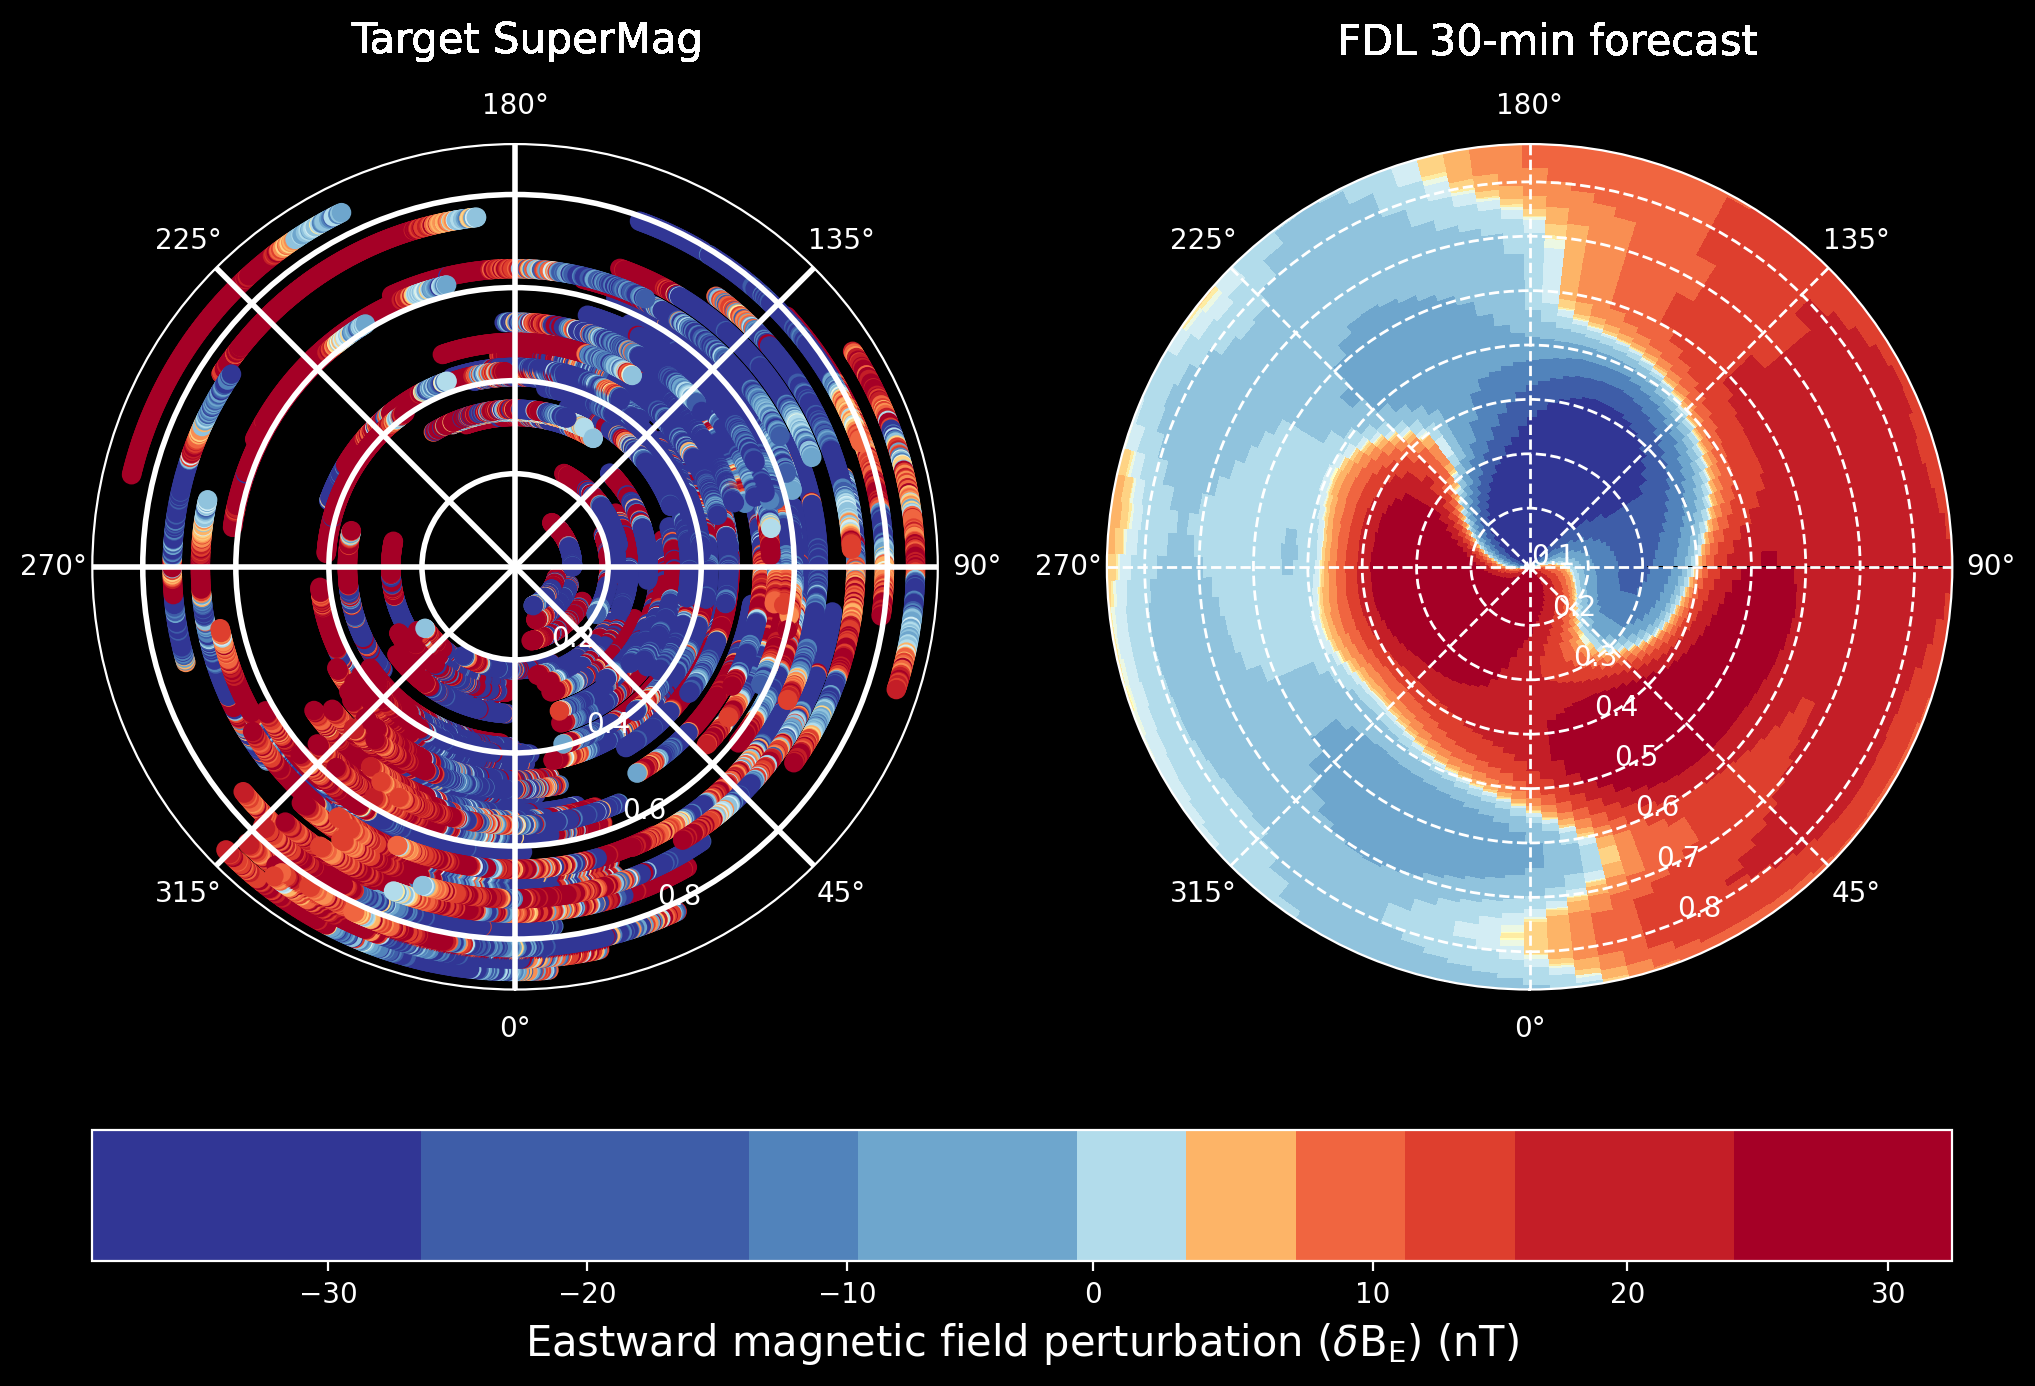

In [193]:
k = 'dbe'
f = 1
fig1 = plt.figure(figsize=(12*f,8*f),dpi=200)
gs = fig1.add_gridspec(8, 2)

camera = Camera(fig1)
theta = _mlt 
phi = _colat 
cmap=cm.get_cmap("RdYlBu_r",17)
ax1 = fig1.add_subplot(gs[:-1,0], projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(gs[:-1,1], projection='polar')
ax2.set_theta_offset(-np.pi/2)
# ax3 = fig1.add_subplot(gs[:-1,2], projection='polar')
# ax3.set_theta_offset(-np.pi/2)
cax = fig1.add_subplot(gs[-1,:])

for time_ind,d in enumerate(storm_dataset.dates[1500:][::10]):
    cax.cla()
    dt = pd.to_datetime(d,unit='s')
    
    dbH2 = fdl_on_grid_gif[k][...,time_ind] #np.sqrt(np.square(Targets['dbe'][:,:,start:end+1])+np.square(Targets['dbn'][:,:,start:end+1]))

    maxval = np.nanpercentile(dbH2,95)
    minval = np.nanpercentile(dbH2,5)
    norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=np.nanmean(dbH2), s1=3, s2=3)

    dbH = fdl_on_grid_gif[k][...,time_ind] #np.sqrt(np.square(fdl_on_weimergrid_gif['dbe'][:,:,start:end+1][...,time_ind])+np.square(fdl_on_weimergrid_gif['dbn'][:,:,start:end+1][...,time_ind]))
    c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)  
    ax2.set_ylim([np.nanmin(Mcolat_sup_all[k][time_ind]),np.nanmax(Mcolat_sup_all[k][time_ind])])
    ax2.grid(linewidth=1,color='white',linestyle='--')
    ax2.text(3.5*f,1.1*f,f"FDL 30-min forecast",fontsize=15*f)

    dbH = Targets[k][time_ind] #np.sqrt(np.square(Targets['dbe'][start:end+1][time_ind])+np.square(Targets['dbn'][start:end+1][time_ind]))
    c3=ax1.scatter(MLT_sup_all[k][time_ind],Mcolat_sup_all[k][time_ind], c=dbH,cmap=cmap,norm=norm,s=36*f)
    ax1.text(3.45*f,1.16*f,f"Target SuperMag",fontsize=15*f)
    ax1.grid(linewidth=2,color='white')
    fig1.colorbar(c3, cax=cax,orientation='horizontal')
    cax.set_xlabel(r'Eastward magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{E}}$) (nT)',fontsize=15)
    camera.snap()

In [194]:
animation = camera.animate()
animation.save('dbe.mp4',bitrate=-1)

In [164]:
# from IPython.display import HTML
# HTML(animation.to_html5_video())